<a id='top'></a>

# Academic Mastery Study

**Improve academic evaluations by predicting whether a student will answer the next test question correctly.** Students taking advantage of practice exercises through various software applications seek an evaluation of their preparedness for formal academic assessments. They would like an an accurate evaluation of any gaps in knowledge and skills without sitting through exercises that repeatedly test established proficiencies and difficulties. The goal is to help test developers build an application that precisely evaluates competencies so that fewer demonstrations of proficiency can accurately determine mastery.

## THE DATA
---
Available from the [Grockit competition on Kaggle]( https://www.kaggle.com/c/WhatDoYouKnow/data).
```python
category_labels.csv
test.csv
training.csv
```
**Test** data does not include `answer_id` or `outcome` (from which correctness could be determined).

The test/training split is derived by finding *users who answered at least 6 questions*, taking **one** of their answers (uniformly random, *from their 6th question to their last*), and inserting it into the **test set**.
* Any *later answers by this user* are removed, 
* and any *earlier answers are included in the **training set***.  
* All answers *from users not in the test set are also used for the training set* (as they may be useful in estimating question parameters or baseline ability distributions).

The **test data** distribution is thus different from **training data** in ways that may be significant.  
* First, it does not include 'timeout' or 'skipped' outcomes: all test results are from the student actually answering the question.  
* Second, it is biased towards users with more questions in the training set and biased towards their later answers.  
* Third, it is one entry per user, so the distribution of various aspects of the data (such as correct/incorrect) is over users, not over all answered questions.

---

**`correct`: `0` or `1` [[TARGET]](#target) - indicates whether the student answered the question correctly.** Rename to **`outcome`** during 'data cleaning'.

**`user_id`**: [[**categorical**]](#user_id) - anonymized numeric identifier for the user answering the question.
       
**`question_id`**: [[**categorical**]](#question_id) - a numeric identifier for the question being answered.
     
**`question_type`**: [[**categorical**]](#question_type) - a numeric code representing the type of question; either `MultipleChoiceOneCorrect` (`0`) for multiple choice, or `SPR` (`1`) for free response questions.
   
**`group_name`**: [[**categorical**]](#group_name) - a numeric code representing the test group for this question `{'act':0, 'gmat':1, 'sat':2}`.

`group_name`

     track_name   
        
        subtrack_name
    
            tag_string

**`track_name`**: [[**categorical**]](#track_name) - the numeric code for the track within the test group for this question (mappings from category fields to numeric values are in `category_labels.csv`).

**`subtrack_name`**: [[**categorical**]](#subtrack_name) - the numeric code for the subtrack within the track for this question (mappings from category fields to numeric values are in category_labels.csv).

**`tag_string`**: [[**categorical**]](#tag_string) - a space-separated list of tag ids for this question (mappings from category fields to numeric values are in category_labels.csv).

**`round_started_at`**: [[**numeric**]](#round_started_at) [use this as reference date] - a UTC timestamp indicating when the question was available to the user.

**`answered_at`**: [[**numeric**]](#answered_at) [minutes from reference date] - a UTC timestamp indicating when the user answered the question (NULL if not answered).

**`deactivated_at`**: [[**numeric**]](#deactivated_at) [minutes from reference date] - a UTC timestamp indicating when the round finished, either because the user answered or the questioned timed-out.

**`game_type`**: [[**categorical**]](#game_type) - indicates the type of game/study session (mappings from category fields to numeric values are in category_labels.csv). More information on each of these is provided in the relevant section of this document.

**`num_players`**: [[**numeric**]](#num_players) - the number of players in the game at the time (multiple users can be viewing the same question simultaneously).

**`date_of_test`**: [numeric] [minutes from reference date] - the date the user entered as their expected test date (if entered). Eliminated during 'data cleaning'.

## DATA WRANGLING
---
Download the `grockit_all_data.zip` file from the [Grockit competition on Kaggle](https://www.kaggle.com/c/WhatDoYouKnow/data). Import and inspect raw training data. Isolate relevant variables and organize dataframe. Rectify missing, invalid or corrupted values.

### Import Packages & Training Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime

In [2]:
# Download grockit_all_data.zip from https://www.kaggle.com/c/WhatDoYouKnow/data,
# and save in the project's raw data directory.

# Read and save CSV file as dataframe:
df = pd.read_csv('../data/raw/training.csv') 

### Inspect Raw Data

In [3]:
# Inspect the current state of the dataset:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851475 entries, 0 to 4851474
Data columns (total 17 columns):
correct             int64
outcome             int64
user_id             int64
question_id         int64
question_type       int64
group_name          int64
track_name          int64
subtrack_name       int64
tag_string          object
round_started_at    object
answered_at         object
deactivated_at      object
answer_id           int64
game_type           int64
num_players         int64
date_of_test        object
question_set_id     int64
dtypes: int64(12), object(5)
memory usage: 629.2+ MB


The raw training dataset contains 17 variables (columns) and 4851475 observations (rows/entries).

In [4]:
# Inspect the structure and first 5 observations of the raw dataset:
df.head()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
0,0,2,85818,5560,0,1,5,14,222 233 240 246,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,6540,7,1,NaN,1567
1,1,1,85818,4681,0,1,5,0,24 49,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,4742,7,1,NaN,1227
2,1,1,85818,1529,0,1,5,0,31 49,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,4309,7,1,NaN,1148
3,1,1,85818,2908,0,1,5,0,31 49,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,4408,7,1,NaN,1168
4,1,1,85818,1773,0,1,5,11,183 194 207,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,10822,7,1,NaN,2318


In [5]:
# Inspect the last 5 observations:
df.tail()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
4851470,1,1,58569,1633,0,1,4,9,47 82 118 161,2009-10-18 17:08:32,2009-10-18 17:09:06,2009-10-18 17:09:06,8811,7,1,2009-09-18,2017
4851471,0,4,58569,1775,0,1,4,1,4 52 135 262,2009-10-18 17:09:24,NaN,2009-10-18 17:10:03,25553,7,1,2009-09-18,2406
4851472,0,4,131842,1655,0,2,8,5,106 130 164,2010-04-19 23:13:02,NaN,2010-04-19 23:13:37,25553,7,5,NaN,368
4851473,0,4,131842,544,0,2,8,3,101 103 134 280,2010-04-19 23:13:48,NaN,2010-04-19 23:14:35,25553,7,5,NaN,470
4851474,0,4,52513,1272,0,2,7,13,239 245,2010-05-18 14:32:59,NaN,2010-05-18 14:35:15,25553,7,1,NaN,3676


Variables can be eliminated. Rows could be indexed and columns could be ordered more appropriately. Some of the date/time observations contain null values.

### Re-Organize Columns

Some columns, such as those not included in the test dataset, can be removed. MultiIndexing by user and start time seems appropriate. Re-ordering the remaining columns becomes necessary. Once the `outcome` column is eliminated, the `correct` column could be renamed to 'outcome', as it is more semantic. New columns, `round_ended_at` and `round_duration`, should be added to hold values for later manipulation and calculation. First, all relevant columns need to be converted to datetime series.

In [6]:
# The first call to convert columns to datetime returned: `ValueError: year 0 is out of range`,
# so this needs to be addressed first. 

# Set up filters and store in variables:
round_started_filter = df['round_started_at'] == '0000-00-00 00:00:00'
answered_at_filter = df['answered_at'] == '0000-00-00 00:00:00'
deactivated_at_filter = df['deactivated_at'] == '0000-00-00 00:00:00'

# Combine filters to apply to the entire dataframe, and inspect the results:
year0_filter = round_started_filter & answered_at_filter & deactivated_at_filter
df[year0_filter]

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
502701,0,2,56022,5488,0,2,8,5,79 106 172 280,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22881,10,1,NaN,306
502702,0,2,56022,2315,0,2,8,5,41 106 143,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22891,10,1,NaN,307
560170,1,1,76463,5488,0,2,8,5,79 106 172 280,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22884,10,1,NaN,306
560171,0,2,76463,2315,0,2,8,5,41 106 143,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,20148,10,1,NaN,307
560172,1,1,76463,225,0,2,6,7,5 131 138,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,2874,10,1,NaN,873
560173,1,1,76463,5277,0,2,6,7,1 5 108 131 269 279,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,2452,10,1,NaN,788
565302,0,2,13469,5488,0,2,8,5,79 106 172 280,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22883,10,1,NaN,306
565303,0,2,13469,2315,0,2,8,5,41 106 143,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,20148,10,1,NaN,307
565304,1,1,13469,225,0,2,6,7,5 131 138,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,2874,10,1,NaN,873
902333,0,2,75026,5488,0,2,8,5,79 106 172 280,0000-00-00 00:00:00,0000-00-00 00:00:00,0000-00-00 00:00:00,22883,10,1,NaN,306


There are 69 observations with no date/time info entered. The most noticeable pattern is that they all involve `game_type` 10 (StudyHallGame), described in the data documentation as "the newest type of game: in these, users are answering their own series of questions as though they were in a solo practice game, but there is a single "study hall" chat where people can ask for help on questions." There are only 2698 observations of this game type in the dataset.

Nonetheless, time data is an important factor in improving the efficiency of testing applications, so dropping the relatively few records with missing data seems appropriate.

In [7]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[year0_filter].index)

In [8]:
# Convert date strings to datetime objects:
df['round_started_at'] = pd.to_datetime(df['round_started_at'])

Trying to convert all three date/time columns resulted in the same error as before. All 69 records eliminated above are the only ones with no time data for `round_started_at`, so that column was converted successfully. The other date/time columns are addressed under the NULL assessment later.

In [9]:
# Drop selected columns and save results:
df = df.drop(['outcome', 'answer_id', 'question_set_id'], axis='columns')

# Change the name of 'correct' column to outcome:
df = df.rename(columns = {'correct':'outcome'})

# Create new columns, round_ended_at and round_duration:
df['round_ended_at'] = ''
df['round_duration'] = ''

# Index the dataset by users, then start time; sort and save:
df = df.set_index(['user_id', 'round_started_at']).sort_index()

In [10]:
# Create and save list of columns to convert to categorical data type:
category_columns = ['group_name', 'track_name', 'subtrack_name', 'question_id', 'question_type', 'game_type']

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    df[column] = df[column].astype('category')

In [11]:
# Inspect the restructured state of the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4851406 entries, (0, 2011-08-26 16:54:31) to (179105, 2010-05-26 06:30:43)
Data columns (total 14 columns):
outcome           int64
question_id       category
question_type     category
group_name        category
track_name        category
subtrack_name     category
tag_string        object
answered_at       object
deactivated_at    object
game_type         category
num_players       int64
date_of_test      object
round_ended_at    object
round_duration    object
dtypes: category(6), int64(2), object(6)
memory usage: 399.1+ MB


The dataframe is now a MultiIndex of users for whom observations are ordered by start time. Since two of the original (raw dataset) columns are now the part of the index, 3 columns were dropped, and 2 new columns created, there are now 14 data columns, 6 of which are category data types.

In [12]:
# Inspect the structure of the new dataframe:
df.head() 

outcome question_id question_type group_name  \
user_id round_started_at                                                    
0       2011-08-26 16:54:31        1        5937             0          0   
        2011-08-26 16:56:12        1         294             0          0   
        2011-08-26 16:56:39        0        5625             0          0   
        2011-08-26 16:57:05        1        4322             0          0   
        2011-08-26 16:57:29        1        5024             0          0   

                            track_name subtrack_name       tag_string  \
user_id round_started_at                                                
0       2011-08-26 16:54:31          2            10   17 122 171 206   
        2011-08-26 16:56:12          2            10    0 100 171 206   
        2011-08-26 16:56:39          2            10   40 124 171 206   
        2011-08-26 16:57:05          2            10   18 139 171 206   
        2011-08-26 16:57:29          2            10  104 127 171 206   

                                     answered_at       deactivated_at  \
user_id round_started_at                                                
0       2011-08-26 16:54:31  2011-08-26 16:55:51  2011-08-26 16:55:53   
        2011-08-26 16:56:12  2011-08-26 16:56:31  2011-08-26 16:56:33   
        2011-08-26 16:56:39  2011-08-26 16:56:54  2011-08-26 16:56:55   
        2011-08-26 16:57:05  2011-08-26 16:57:24  2011-08-26 16:57:25   
        2011-08-26 16:57:29  2011-08-26 16:57:51  2011-08-26 16:57:52   

                            game_type  num_players date_of_test  \
user_id round_started_at                                          
0       2011-08-26 16:54:31         7            1          NaN   
        2011-08-26 16:56:12         7            1          NaN   
        2011-08-26 16:56:39         7            1          NaN   
        2011-08-26 16:57:05         7            1          NaN   
        2011-08-26 16:57:29         7            1          NaN   

                            round_ended_at round_duration  
user_id round_started_at                                   
0       2011-08-26 16:54:31                                
        2011-08-26 16:56:12                                
        2011-08-26 16:56:39                                
        2011-08-26 16:57:05                                
        2011-08-26 16:57:29

In [13]:
# Reorder the columns and save:
column_labels = ['answered_at', 'deactivated_at', 'round_ended_at', 'round_duration', 
                 'outcome', 'group_name', 'track_name', 'subtrack_name', 'tag_string', 
                 'question_id', 'question_type', 'game_type', 'num_players', 'date_of_test']
df = df[column_labels]

# Reinspect the structure to confirm:
df.head(10)

answered_at       deactivated_at  \
user_id round_started_at                                                
0       2011-08-26 16:54:31  2011-08-26 16:55:51  2011-08-26 16:55:53   
        2011-08-26 16:56:12  2011-08-26 16:56:31  2011-08-26 16:56:33   
        2011-08-26 16:56:39  2011-08-26 16:56:54  2011-08-26 16:56:55   
        2011-08-26 16:57:05  2011-08-26 16:57:24  2011-08-26 16:57:25   
        2011-08-26 16:57:29  2011-08-26 16:57:51  2011-08-26 16:57:52   
        2011-08-26 16:57:58  2011-08-26 16:58:17  2011-08-26 16:58:18   
        2011-08-26 16:58:22  2011-08-26 16:58:35  2011-08-26 16:58:41   
1       2011-02-14 07:34:34                  NaN  2011-02-14 07:37:04   
        2011-02-14 07:37:06  2011-02-14 07:38:06  2011-02-14 07:38:06   
        2011-02-14 07:38:08  2011-02-14 07:40:23  2011-02-14 07:40:23   

                            round_ended_at round_duration  outcome group_name  \
user_id round_started_at                                                        
0       2011-08-26 16:54:31                                      1          0   
        2011-08-26 16:56:12                                      1          0   
        2011-08-26 16:56:39                                      0          0   
        2011-08-26 16:57:05                                      1          0   
        2011-08-26 16:57:29                                      1          0   
        2011-08-26 16:57:58                                      0          0   
        2011-08-26 16:58:22                                      1          0   
1       2011-02-14 07:34:34                                      0          1   
        2011-02-14 07:37:06                                      0          1   
        2011-02-14 07:38:08                                      0          1   

                            track_name subtrack_name       tag_string  \
user_id round_started_at                                                
0       2011-08-26 16:54:31          2            10   17 122 171 206   
        2011-08-26 16:56:12          2            10    0 100 171 206   
        2011-08-26 16:56:39          2            10   40 124 171 206   
        2011-08-26 16:57:05          2            10   18 139 171 206   
        2011-08-26 16:57:29          2            10  104 127 171 206   
        2011-08-26 16:57:58          2            10  100 124 171 206   
        2011-08-26 16:58:22          2            10   62 127 171 206   
1       2011-02-14 07:34:34          4             9     4 77 161 251   
        2011-02-14 07:37:06          4             9    14 74 135 161   
        2011-02-14 07:38:08          4             9  14 68 71 77 161   

                            question_id question_type game_type  num_players  \
user_id round_started_at                                                       
0       2011-08-26 16:54:31        5937             0         7            1   
        2011-08-26 16:56:12         294             0         7            1   
        2011-08-26 16:56:39        5625             0         7            1   
        2011-08-26 16:57:05        4322             0         7            1   
        2011-08-26 16:57:29        5024             0         7            1   
        2011-08-26 16:57:58        1233             0         7            1   
        2011-08-26 16:58:22        2546             0         7            1   
1       2011-02-14 07:34:34        4952             0         2            1   
        2011-02-14 07:37:06        1856             0         2            1   
        2011-02-14 07:38:08        4103             0         2            1   

                            date_of_test  
user_id round_started_at                  
0       2011-08-26 16:54:31          NaN  
        2011-08-26 16:56:12          NaN  
        2011-08-26 16:56:39          NaN  
        2011-08-26 16:57:05          NaN  
        2011-08-26 16:57:29          NaN  
        2011-08-26 16:57:58          NaN  
     

### Assess & Handle Missing Data

In [14]:
# Get a null count for each column in the dataframe:
df.isnull().sum() 

answered_at        556018
deactivated_at         30
round_ended_at          0
round_duration          0
outcome                 0
group_name              0
track_name              0
subtrack_name           0
tag_string              0
question_id             0
question_type           0
game_type               0
num_players             0
date_of_test      3824139
dtype: int64

According to information provided with the datasets for this project, `date_of_test` is the date the user entered as their expected test date (**if entered**). Nearly 80% of these values are NULL, but that does not indicate how many users are associated with 'no date entered'. This is explored below.

The information also indicates that missing values from the `answered_at` column are NULL if not answered, so NULL in this case seems to be valuable information.

The NULL count for `deactivated_at` is a bit of a mystery and is examined first.

In [15]:
# Create the filter for NULL values in the deactivated_at column:
null_deactivated_filter = df.deactivated_at.isnull()

# Apply the filter to the dataframe and inspect:
df[null_deactivated_filter]

,,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players,date_of_test
user_id,round_started_at,,,,,,,,,,,,,,
21595,2009-04-20 21:17:58,NaN,NaN,,,0,1,4,1,14 52 77 160 279,4494,0,7,5,NaN
33450,2009-02-20 17:55:30,NaN,NaN,,,0,1,5,14,233 240 246,4632,0,7,1,NaN
35763,2009-04-21 06:26:50,2009-04-21 06:27:44,NaN,,,0,1,4,9,14 55 77 135 161,4723,0,7,2,2009-07-17
48073,2009-06-24 15:00:43,2009-06-24 15:02:11,NaN,,,0,2,6,15,15 137 204 261 279,4802,1,7,5,NaN
51708,2008-12-24 20:20:17,NaN,NaN,,,0,1,5,11,193 207,4371,0,7,1,NaN
55785,2008-11-13 18:34:55,NaN,NaN,,,0,1,5,14,220 224 227 228 246,2734,0,7,4,NaN
57882,2008-10-21 02:43:55,NaN,NaN,,,0,1,4,9,14 113 161 250 279,5311,0,7,1,NaN
61332,2009-04-20 21:17:58,NaN,NaN,,,0,1,4,1,14 52 77 160 279,4494,0,7,5,2009-07-24
62107,2009-06-24 15:00:43,2009-06-24 15:03:18,NaN,,,0,2,6,15,15 137 204 261 279,4802,1,7,5,2009-12-05


Of the 30 NULL observations for `deactivated_at`, all of them were marked incorrect and all of them are for the game type 7, which is described as "the main type of game: in these, everyone in the game is seeing the same question at the same time; once everyone has answered, the answer is displayed; once everyone is ready to continue, the round advances to a new question."

Again, time is important information in this study. Observations above with a date/time entered for `answered_at` provide the necessary information and should remain - the NULL values for `deactivated_at` in those rows can be filled or ignored. Since the observations with NULL values for both columns are not useful, they are dropped.

In [16]:
# Drop all rows with NULL values for both answered_at and deactivated_at, save the rest:
df = df.dropna(subset=['answered_at', 'deactivated_at'], how='all') 

# Create new filter for NULL values in the deactivated_at column:
null_deactivated = df.deactivated_at.isnull()

# Confirm the remaining values for deactivated_at:
df[null_deactivated]

answered_at deactivated_at  \
user_id round_started_at                                          
35763   2009-04-21 06:26:50  2009-04-21 06:27:44            NaN   
48073   2009-06-24 15:00:43  2009-06-24 15:02:11            NaN   
62107   2009-06-24 15:00:43  2009-06-24 15:03:18            NaN   
        2009-06-24 15:14:55  2009-06-24 15:16:17            NaN   
65358   2009-06-24 15:00:43  2009-06-24 15:01:58            NaN   
79815   2009-05-17 18:45:38  2009-05-17 18:46:40            NaN   
97518   2009-06-29 15:19:56  2009-06-29 15:21:57            NaN   
107154  2009-04-15 22:33:50  2009-04-15 22:34:29            NaN   
122692  2009-06-25 17:35:54  2009-06-25 17:37:24            NaN   
135617  2009-04-29 16:44:09  2009-04-29 16:45:49            NaN   

                            round_ended_at round_duration  outcome group_name  \
user_id round_started_at                                                        
35763   2009-04-21 06:26:50                                      0          1   
48073   2009-06-24 15:00:43                                      0          2   
62107   2009-06-24 15:00:43                                      0          2   
        2009-06-24 15:14:55                                      0          2   
65358   2009-06-24 15:00:43                                      0          2   
79815   2009-05-17 18:45:38                                      0          1   
97518   2009-06-29 15:19:56                                      0          2   
107154  2009-04-15 22:33:50                                      0          2   
122692  2009-06-25 17:35:54                                      0          2   
135617  2009-04-29 16:44:09                                      0          2   

                            track_name subtrack_name           tag_string  \
user_id round_started_at                                                    
35763   2009-04-21 06:26:50          4             9     14 55 77 135 161   
48073   2009-06-24 15:00:43          6            15   15 137 204 261 279   
62107   2009-06-24 15:00:43          6            15   15 137 204 261 279   
        2009-06-24 15:14:55          6            15   15 137 204 261 279   
65358   2009-06-24 15:00:43          6            15   15 137 204 261 279   
79815   2009-05-17 18:45:38          5            14  220 224 227 228 246   
97518   2009-06-29 15:19:56          6            15   15 137 204 261 279   
107154  2009-04-15 22:33:50          6            15   78 137 147 261 279   
122692  2009-06-25 17:35:54          6            15   15 137 204 261 279   
135617  2009-04-29 16:44:09          6            15            5 138 261   

                            question_id question_type game_type  num_players  \
user_id round_started_at                                                       
35763   2009-04-21 06:26:50        4723             0         7            2   
48073   2009-06-24 15:00:43        4802             1         7            5   
62107   2009-06-24 15:00:43        4802             1         7            5   
        2009-06-24 15:14:55        4802             1         7            5   
65358   2009-06-24 15:00:43        4802             1         7            5   
79815   2009-05-17 18:45:38        2734             0         7            3   
97518   2009-06-29 15:19:56        4802             1         7            5   
107154  2009-04-15 22:33:50        2316             1         7            5   
122692  2009-06-25 17:35:54        4802             1         7            3   
135617  2009-04-29 16:44:09        2096             1         7            2   

                            date_of_test  
user_id round_started_at                  
35763   2009-04-21 06:26:50   2009-07-17  
48073   2009-06-24 15:00:43          NaN  
62107   2009-06-24 15:00:43   2009-12-05  
        2009-06-24 15:14:55   2009-12-05  
65358   2009-06-24 15:00:43          NaN  
79815   2009-05-17 18:45:38          NaN  
97518   2009-06-29 15:19:56  

In [17]:
# Get the number of users remaining after dropping observations:
len(df.reset_index().groupby('user_id').nunique())

179093

In [18]:
# Get the number of users who entered a value for date_of_test:
len(df[df.date_of_test.notnull()].groupby('user_id').sum())

22534

In [19]:
# Get the number of users who did not enter a value for date_of_test:
len(df[df.date_of_test.isnull()].groupby('user_id').sum())

156559

Only 22,534 of the 179,093 users provided an expected test date. Given that nearly 90% of the users did not provide a date, this column will not be analyzed.

In [20]:
# Drop selected columns and save results:
df = df.drop('date_of_test', axis='columns')

In [21]:
# Get a new null count for each column in the dataframe:
df.isnull().sum() 

answered_at       555998
deactivated_at        10
round_ended_at         0
round_duration         0
outcome                0
group_name             0
track_name             0
subtrack_name          0
tag_string             0
question_id            0
question_type          0
game_type              0
num_players            0
dtype: int64

This is expected and useful.

---
**Reminder to Self**: Noticed in game_type notes below and need to address this: "NULL: 6 - values represent a data collection failure." So, NULL counts are not showing up for the game_type column because they are represented by 6.

### Resolve Earlier NULL Related Issues

In [22]:
# Convert date strings to datetime objects; need to ‘coerce’ errors, 
# since there are NULLs that will remain in these columns:
df['answered_at'] = pd.to_datetime(df['answered_at'], errors='coerce') 
df['deactivated_at'] = pd.to_datetime(df['deactivated_at'], errors='coerce')
df['round_ended_at'] = pd.to_datetime(df['round_ended_at'], errors='coerce')
df['round_duration'] = pd.to_datetime(df['round_duration'], errors='coerce')

In [23]:
# Fill round_ended_at with answered_at if not null, otherwise fill with deactivated_at:
df['round_ended_at'] = df['answered_at'].fillna(df['deactivated_at'])

# Inspect the null answered_at observations to confirm:
df[df.answered_at.isnull()].head()

answered_at      deactivated_at  \
user_id round_started_at                                      
1       2011-02-14 07:34:34         NaT 2011-02-14 07:37:04   
        2011-02-14 07:41:45         NaT 2011-02-14 07:44:16   
        2011-02-14 07:48:09         NaT 2011-02-14 07:50:40   
        2011-02-14 07:50:42         NaT 2011-02-14 07:53:12   
        2011-02-14 07:53:45         NaT 2011-02-14 07:54:04   

                                 round_ended_at round_duration  outcome  \
user_id round_started_at                                                  
1       2011-02-14 07:34:34 2011-02-14 07:37:04            NaT        0   
        2011-02-14 07:41:45 2011-02-14 07:44:16            NaT        0   
        2011-02-14 07:48:09 2011-02-14 07:50:40            NaT        0   
        2011-02-14 07:50:42 2011-02-14 07:53:12            NaT        0   
        2011-02-14 07:53:45 2011-02-14 07:54:04            NaT        0   

                            group_name track_name subtrack_name  \
user_id round_started_at                                          
1       2011-02-14 07:34:34          1          4             9   
        2011-02-14 07:41:45          1          4             9   
        2011-02-14 07:48:09          1          4             9   
        2011-02-14 07:50:42          1          4             9   
        2011-02-14 07:53:45          1          4             9   

                                   tag_string question_id question_type  \
user_id round_started_at                                                  
1       2011-02-14 07:34:34      4 77 161 251        4952             0   
        2011-02-14 07:41:45      4 14 161 279        1976             0   
        2011-02-14 07:48:09     4 148 161 279        1080             0   
        2011-02-14 07:50:42  4 59 118 161 279        2065             0   
        2011-02-14 07:53:45   14 68 71 77 161        4103             0   

                            game_type  num_players  
user_id round_started_at                            
1       2011-02-14 07:34:34         2            1  
        2011-02-14 07:41:45         2            1  
        2011-02-14 07:48:09         2            1  
        2011-02-14 07:50:42         2            1  
        2011-02-14 07:53:45         9            1

### Assess & Handle Possible Duplicate Records

Duplicates of user_id are expected and addressed by MultiIndexing with start times; however, there are a number of features that in combination should be checked. First: `user_id`, `round_started_at`, `round_ended_at`, since it seems impossible for one user to have the same time stamp more than once.

In [24]:
# Reset the index and save all duplicates by user_id and round_started_at:
duplicates = df.reset_index()
duplicates = duplicates[duplicates.duplicated(['user_id', 'round_started_at', 'round_ended_at'], keep=False)]

# Set options to inspect ALL of the observations:
pd.options.display.max_rows = 650
duplicates

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players
161193,5901,2011-07-14 16:45:03,NaT,2011-07-14 16:45:03,2011-07-14 16:45:03,NaT,0,2,7,8,145 177 200,4761,0,7,1
161194,5901,2011-07-14 16:45:03,NaT,2011-07-14 16:45:03,2011-07-14 16:45:03,NaT,0,2,7,8,145 177 190,4465,0,7,1
342188,12996,2011-10-22 02:17:34,NaT,2011-10-22 02:17:34,2011-10-22 02:17:34,NaT,0,0,0,2,57 65 141 173,213,0,7,1
342189,12996,2011-10-22 02:17:34,NaT,2011-10-22 02:17:34,2011-10-22 02:17:34,NaT,0,0,0,2,65 107 172,5839,0,7,1
342209,12996,2011-10-22 02:17:49,NaT,2011-10-22 02:17:49,2011-10-22 02:17:49,NaT,0,0,0,2,65 165,5010,0,7,1
342210,12996,2011-10-22 02:17:49,NaT,2011-10-22 02:17:49,2011-10-22 02:17:49,NaT,0,0,0,2,65 107 172,4758,0,7,1
342214,12996,2011-10-22 02:17:51,NaT,2011-10-22 02:17:51,2011-10-22 02:17:51,NaT,0,0,0,2,65 144 274,136,0,7,1
342215,12996,2011-10-22 02:17:51,NaT,2011-10-22 02:17:51,2011-10-22 02:17:51,NaT,0,0,0,2,65 173 267,5345,0,7,1
387658,14659,2011-10-13 06:48:11,2011-10-12 23:51:11,2011-10-12 23:51:11,2011-10-12 23:51:11,NaT,0,0,1,6,64 125 268 279,897,0,6,1
387659,14659,2011-10-13 06:48:11,2011-10-12 23:51:11,2011-10-12 23:51:11,2011-10-12 23:51:11,NaT,0,0,1,6,64 125 268 279,897,0,6,1


A number of the observations above involve the same start and end time. This warrants a closer look. Another anomaly involves a number of users with `round_started_at` times later than `round_ended_at`, but the pattern that emerged from inspecting such is that all of the observations involve 10-13-2011. 

In [25]:
# Reset to default the number of rows returned:
pd.reset_option('max_rows')

# Get all observations for 2011-10-13 by round_started_at:
df.loc[(slice(None), slice('2011-10-13', '2011-10-13')), :]

answered_at      deactivated_at  \
user_id round_started_at                                              
890     2011-10-13 11:02:04 2011-10-13 11:03:00 2011-10-13 11:03:14   
        2011-10-13 11:03:50 2011-10-13 11:05:13 2011-10-13 11:05:50   
        2011-10-13 11:08:20                 NaT 2011-10-13 11:09:10   
        2011-10-13 11:09:51 2011-10-13 11:10:29 2011-10-13 11:10:33   
        2011-10-13 11:10:46 2011-10-13 11:11:59 2011-10-13 11:12:02   
        2011-10-13 11:12:07 2011-10-13 11:13:03 2011-10-13 11:13:05   
        2011-10-13 11:13:11 2011-10-13 11:14:41 2011-10-13 11:14:43   
2126    2011-10-13 21:00:11 2011-10-13 21:00:33 2011-10-13 21:01:01   
        2011-10-13 21:02:27 2011-10-13 21:04:02 2011-10-13 21:04:06   
        2011-10-13 21:04:43 2011-10-13 21:05:21 2011-10-13 21:05:39   
        2011-10-13 21:05:56 2011-10-13 21:06:59 2011-10-13 21:07:12   
        2011-10-13 21:07:54 2011-10-13 21:08:44 2011-10-13 21:08:58   
        2011-10-13 21:09:08 2011-10-13 21:11:39 2011-10-13 21:11:42   
        2011-10-13 21:11:51 2011-10-13 21:12:22 2011-10-13 21:12:47   
        2011-10-13 21:13:27 2011-10-13 21:15:47 2011-10-13 21:15:50   
        2011-10-13 21:17:39                 NaT 2011-10-13 21:18:30   
        2011-10-13 21:18:32 2011-10-13 21:18:59 2011-10-13 21:19:03   
        2011-10-13 21:19:03                 NaT 2011-10-13 21:20:28   
2210    2011-10-13 01:07:40                 NaT 2011-10-13 01:09:10   
        2011-10-13 01:10:08                 NaT 2011-10-13 01:11:19   
2869    2011-10-13 00:38:53 2011-10-13 00:39:39 2011-10-13 00:41:55   
        2011-10-13 00:44:56 2011-10-13 00:46:59 2011-10-13 00:47:58   
        2011-10-13 00:50:59 2011-10-13 00:51:29 2011-10-13 00:54:00   
        2011-10-13 00:57:02 2011-10-13 00:57:22 2011-10-13 01:00:03   
        2011-10-13 01:01:06 2011-10-13 01:02:11 2011-10-13 01:02:12   
        2011-10-13 01:05:12 2011-10-13 01:05:29 2011-10-13 01:07:13   
        2011-10-13 01:08:28 2011-10-13 01:08:44 2011-10-13 01:10:44   
        2011-10-13 01:11:02 2011-10-13 01:11:29 2011-10-13 01:13:16   
        2011-10-13 01:13:59 2011-10-13 01:16:17 2011-10-13 01:17:00   
        2011-10-13 01:17:49 2011-10-13 01:17:58 2011-10-13 01:18:46   
...                                         ...                 ...   
175563  2011-10-13 03:14:57 2011-10-13 03:15:42 2011-10-13 03:15:43   
175971  2011-10-13 09:15:35 2011-10-13 09:15:54 2011-10-13 09:15:57   
        2011-10-13 09:18:27                 NaT 2011-10-13 09:18:49   
176065  2011-10-13 22:39:13 2011-10-13 22:39:40 2011-10-13 22:39:45   
        2011-10-13 22:39:45 2011-10-13 22:41:39 2011-10-13 22:41:41   
        2011-10-13 22:41:41 2011-10-13 22:42:28 2011-10-13 22:42:30   
        2011-10-13 22:42:30 2011-10-13 22:43:51 2011-10-13 22:43:52   
        2011-10-13 22:43:52 2011-10-13 22:45:04 2011-10-13 22:45:07   
177208  2011-10-13 04:17:26 2011-10-13 04:17:53 2011-10-13 04:17:59   
        2011-10-13 04:20:06 2011-10-13 04:20:18 2011-10-13 04:20:20   
        2011-10-13 04:20:23 2011-10-13 04:20:31 2011-10-13 04:20:32   
        2011-10-13 04:20:34 2011-10-13 04:20:50 2011-10-13 04:20:52   
        2011-10-13 04:20:54 2011-10-13 04:21:26 2011-10-13 04:21:27   
178519  2011-10-13 17:48:19 2011-10-13 17:49:48 2011-10-13 17:49:50   
        2011-10-13 17:50:02 2011-10-13 17:51:16 2011-10-13 17:51:19   
        2011-10-13 17:51:40 2011-10-13 17:53:36 2011-10-13 17:53:38   
        2011-10-13 17:54:19 2011-10-13 17:55:36 2011-10-13 17:55:39   
        2011-10-13 17:55:53 2011-10-13 17:56:54 2011-10-13 17:56:55   
        2011-10-13 17:57:18                 NaT 2011-10-13 17:58:24   
        2011-10-13 18:01:50 2011-10-13 18:02:32 2011-10-13 18:02:32   
        2011-10-13 18:02:38 2011-10-13 18:03:07 2011-10-13 18:03:08   
        2011-10-13 18:03:10 2011-10-13 18:05:08 2011-10-13 18:05:09   
        2011-10-13 18:05:41 2011-10-13 18:06:43 2011-10-13 18:06:46   
178993  2011-10-13 18:43:25 2011-10-13 18:43:47 2011-10-13 1

A quick inspection of the rows above reveals that the noticeable weirdness before is not true for all of the 10-13-2011 observations, so a revised approach:

In [26]:
# Get all observations where round_ended_at times are before round_started_at time:
df[df.index.get_level_values('round_started_at') > df['round_ended_at']]

answered_at      deactivated_at  \
user_id round_started_at                                              
14418   2011-10-13 11:01:49 2011-10-13 04:02:10 2011-10-13 04:02:10   
14659   2011-10-13 06:48:11 2011-10-12 23:51:11 2011-10-12 23:51:11   
        2011-10-13 06:48:11 2011-10-12 23:51:11 2011-10-12 23:51:11   
        2011-10-13 06:54:11 2011-10-12 23:57:11 2011-10-12 23:57:11   
        2011-10-13 06:54:11 2011-10-12 23:57:11 2011-10-12 23:57:11   
        2011-10-13 07:00:11 2011-10-13 00:03:11 2011-10-13 00:03:11   
        2011-10-13 07:00:11 2011-10-13 00:03:11 2011-10-13 00:03:11   
        2011-10-13 07:06:11 2011-10-13 00:09:11 2011-10-13 00:09:11   
        2011-10-13 07:06:11 2011-10-13 00:09:11 2011-10-13 00:09:11   
        2011-10-13 07:12:11 2011-10-13 00:15:11 2011-10-13 00:15:11   
        2011-10-13 07:12:11 2011-10-13 00:15:11 2011-10-13 00:15:11   
        2011-10-13 07:18:12 2011-10-13 00:21:12 2011-10-13 00:21:12   
        2011-10-13 07:18:12 2011-10-13 00:21:12 2011-10-13 00:21:12   
        2011-10-13 07:24:12 2011-10-13 00:27:12 2011-10-13 00:27:12   
        2011-10-13 07:24:12 2011-10-13 00:27:12 2011-10-13 00:27:12   
        2011-10-13 07:30:12 2011-10-13 00:33:12 2011-10-13 00:33:12   
        2011-10-13 07:30:12 2011-10-13 00:33:12 2011-10-13 00:33:12   
        2011-10-13 07:36:12 2011-10-13 00:39:12 2011-10-13 00:39:12   
        2011-10-13 07:36:12 2011-10-13 00:39:12 2011-10-13 00:39:12   
        2011-10-13 07:42:12 2011-10-13 00:45:12 2011-10-13 00:45:12   
        2011-10-13 07:42:12 2011-10-13 00:45:12 2011-10-13 00:45:12   
51203   2011-10-13 08:27:48 2011-10-13 04:33:48 2011-10-13 04:33:48   
        2011-10-13 08:27:48 2011-10-13 04:33:48 2011-10-13 04:33:48   
        2011-10-13 11:02:18 2011-10-13 04:08:18 2011-10-13 04:08:18   
        2011-10-13 11:02:18 2011-10-13 04:08:18 2011-10-13 04:08:18   
        2011-10-13 11:10:48 2011-10-13 04:16:48 2011-10-13 04:16:48   
        2011-10-13 11:10:48 2011-10-13 04:16:48 2011-10-13 04:16:48   
        2011-10-13 11:19:18 2011-10-13 04:25:18 2011-10-13 04:25:18   
        2011-10-13 11:19:18 2011-10-13 04:25:18 2011-10-13 04:25:18   
        2011-10-13 11:36:18 2011-10-13 04:42:18 2011-10-13 04:42:18   
...                                         ...                 ...   
155840  2011-10-13 05:58:19 2011-10-13 02:04:19 2011-10-13 02:04:19   
        2011-10-13 05:58:19 2011-10-13 02:04:19 2011-10-13 02:04:19   
        2011-10-13 06:23:49 2011-10-13 02:29:49 2011-10-13 02:29:49   
        2011-10-13 06:23:49 2011-10-13 02:29:49 2011-10-13 02:29:49   
        2011-10-13 08:10:53 2011-10-13 01:16:53 2011-10-13 01:16:53   
        2011-10-13 08:10:53 2011-10-13 01:16:53 2011-10-13 01:16:53   
        2011-10-13 08:17:03 2011-10-13 01:25:50 2011-10-13 01:25:50   
        2011-10-13 08:17:03 2011-10-13 01:25:50 2011-10-13 01:25:50   
        2011-10-13 08:26:11 2011-10-13 01:32:11 2011-10-13 01:32:11   
        2011-10-13 08:26:11 2011-10-13 01:32:11 2011-10-13 01:32:11   
        2011-10-13 08:32:20 2011-10-13 01:38:48 2011-10-13 01:38:48   
        2011-10-13 08:32:20 2011-10-13 01:38:48 2011-10-13 01:38:48   
        2011-10-13 08:41:18 2011-10-13 01:47:18 2011-10-13 01:47:18   
        2011-10-13 08:41:18 2011-10-13 01:47:18 2011-10-13 01:47:18   
        2011-10-13 08:49:49 2011-10-13 01:55:49 2011-10-13 01:55:49   
        2011-10-13 08:49:49 2011-10-13 01:55:49 2011-10-13 01:55:49   
        2011-10-13 09:06:49 2011-10-13 02:12:49 2011-10-13 02:12:49   
        2011-10-13 09:06:49 2011-10-13 02:12:49 2011-10-13 02:12:49   
        2011-10-13 09:15:19 2011-10-13 02:21:19 2011-10-13 02:21:19   
        2011-10-13 09:15:19 2011-10-13 02:21:19 2011-10-13 02:21:19   
163187  2011-10-13 06:57:45 2011-10-13 00:01:45 2011-10-13 00:01:45   
        2011-10-13 07:03:16 2011-10-13 00:06:16 2011-10-13 00:06:16   
        2011-10-13 07:09:16 2011-10-13 00:13:16 2011-10-13 00:13:16   
        2011-10-13 07:14:46 2011-10-13 00:17:46 2011-10-13 0

In [27]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df.index.get_level_values('round_started_at') > df['round_ended_at']].index)

In [28]:
# Get all observations where round_started_at times are the same as round_ended_at time:
df[df.index.get_level_values('round_started_at') == df['round_ended_at']]

answered_at      deactivated_at  \
user_id round_started_at                                              
87      2009-12-02 13:11:34                 NaT 2009-12-02 13:11:34   
91      2010-05-08 15:23:03                 NaT 2010-05-08 15:23:03   
97      2011-04-03 21:30:45 2011-04-03 21:30:45 2011-04-03 21:30:46   
372     2009-06-23 08:39:23                 NaT 2009-06-23 08:39:23   
611     2011-09-07 14:49:32                 NaT 2011-09-07 14:49:32   
        2011-09-07 16:16:46                 NaT 2011-09-07 16:16:46   
        2011-09-07 16:16:50                 NaT 2011-09-07 16:16:50   
        2011-09-07 16:16:53                 NaT 2011-09-07 16:16:53   
        2011-09-07 17:13:39                 NaT 2011-09-07 17:13:39   
617     2009-11-28 23:13:01                 NaT 2009-11-28 23:13:01   
        2009-11-29 01:53:26                 NaT 2009-11-29 01:53:26   
632     2011-05-31 13:59:19                 NaT 2011-05-31 13:59:19   
693     2011-05-29 07:53:42                 NaT 2011-05-29 07:53:42   
709     2009-09-29 18:42:28                 NaT 2009-09-29 18:42:28   
        2009-09-29 19:54:37                 NaT 2009-09-29 19:54:37   
900     2009-12-17 10:26:52                 NaT 2009-12-17 10:26:52   
        2010-05-12 11:40:29                 NaT 2010-05-12 11:40:29   
1018    2011-06-15 05:55:24                 NaT 2011-06-15 05:55:24   
1092    2009-11-19 02:33:12                 NaT 2009-11-19 02:33:12   
1101    2009-12-08 22:34:18                 NaT 2009-12-08 22:34:18   
1192    2011-11-01 18:43:21 2011-11-01 18:43:21 2011-11-01 18:43:22   
1287    2010-08-07 05:57:21                 NaT 2010-08-07 05:57:21   
1337    2011-10-21 15:29:09                 NaT 2011-10-21 15:29:09   
1406    2009-10-16 23:44:44                 NaT 2009-10-16 23:44:44   
1433    2011-01-01 20:12:42                 NaT 2011-01-01 20:12:42   
1447    2010-03-11 14:37:47                 NaT 2010-03-11 14:37:47   
        2010-03-11 14:38:19                 NaT 2010-03-11 14:38:19   
        2010-03-11 14:38:31                 NaT 2010-03-11 14:38:31   
        2010-03-11 14:38:40                 NaT 2010-03-11 14:38:40   
        2010-03-11 14:40:01                 NaT 2010-03-11 14:40:01   
...                                         ...                 ...   
176767  2011-06-08 03:16:25 2011-06-08 03:16:25 2011-06-08 03:16:26   
        2011-06-08 03:16:59 2011-06-08 03:16:59 2011-06-08 03:17:00   
        2011-06-08 03:17:05 2011-06-08 03:17:05 2011-06-08 03:17:07   
        2011-06-08 03:17:07 2011-06-08 03:17:07 2011-06-08 03:17:08   
        2011-06-08 03:17:41 2011-06-08 03:17:41 2011-06-08 03:17:43   
        2011-06-08 03:17:43 2011-06-08 03:17:43 2011-06-08 03:17:45   
176792  2011-02-06 16:35:17                 NaT 2011-02-06 16:35:17   
176896  2011-08-14 19:21:25                 NaT 2011-08-14 19:21:25   
        2011-08-20 16:16:57                 NaT 2011-08-20 16:16:57   
177200  2010-02-09 18:19:22                 NaT 2010-02-09 18:19:22   
177203  2009-10-30 10:20:32                 NaT 2009-10-30 10:20:32   
177321  2011-01-15 20:27:20                 NaT 2011-01-15 20:27:20   
177339  2009-10-30 07:37:56                 NaT 2009-10-30 07:37:56   
        2009-12-01 00:15:24                 NaT 2009-12-01 00:15:24   
177552  2011-10-06 01:06:19                 NaT 2011-10-06 01:06:19   
        2011-10-06 01:07:23                 NaT 2011-10-06 01:07:23   
        2011-10-07 02:09:58                 NaT 2011-10-07 02:09:58   
177649  2010-09-24 12:56:18                 NaT 2010-09-24 12:56:18   
177719  2010-02-14 14:09:44                 NaT 2010-02-14 14:09:44   
177837  2009-03-19 21:01:03                 NaT 2009-03-19 21:01:03   
178423  2010-02-11 15:56:03                 NaT 2010-02-11 15:56:03   
        2010-02-11 15:56:13                 NaT 2010-02-11 15:56:13   
178528  2009-12-27 19:49:57 2009-12-27 19:49:57 2009-12-27 19:49:57   
        2009-12-27 19:49:59 2009-12-27 19:49:59 2009-12-27 1

Nothing jumps out to indicate another pattern or cause, but it seems illogical that a user would have time to read a question within one second. These will be dropped.

In [29]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df.index.get_level_values('round_started_at') == df['round_ended_at']].index)

In [30]:
# Drop duplicates of the remaining observations:
df = df.reset_index().drop_duplicates(['user_id', 'round_started_at', 'round_ended_at'])
df = df.set_index(['user_id', 'round_started_at']).sort_index()

### One More Tweak Before Further Exploration

In [31]:
# Split the space delimited tag_string into a list of tag_ids
df['tag_string'] = df.tag_string.str.split(' ')

# Change the name of 'tag_string' column to tag_ids:
df = df.rename(columns = {'tag_string':'tag_ids'})

# Confirm the changes:
df.tag_ids.head()

user_id  round_started_at   
0        2011-08-26 16:54:31     [17, 122, 171, 206]
         2011-08-26 16:56:12      [0, 100, 171, 206]
         2011-08-26 16:56:39     [40, 124, 171, 206]
         2011-08-26 16:57:05     [18, 139, 171, 206]
         2011-08-26 16:57:29    [104, 127, 171, 206]
Name: tag_ids, dtype: object

In [32]:
# Re-inspect the state and structure of the dataframe:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4845888 entries, (0, 2011-08-26 16:54:31) to (179105, 2010-05-26 06:30:43)
Data columns (total 13 columns):
answered_at       datetime64[ns]
deactivated_at    datetime64[ns]
round_ended_at    datetime64[ns]
round_duration    datetime64[ns]
outcome           int64
group_name        category
track_name        category
subtrack_name     category
tag_ids           object
question_id       category
question_type     category
game_type         category
num_players       int64
dtypes: category(6), datetime64[ns](4), int64(2), object(1)
memory usage: 361.7+ MB
None


answered_at      deactivated_at  \
user_id round_started_at                                              
0       2011-08-26 16:54:31 2011-08-26 16:55:51 2011-08-26 16:55:53   
        2011-08-26 16:56:12 2011-08-26 16:56:31 2011-08-26 16:56:33   
        2011-08-26 16:56:39 2011-08-26 16:56:54 2011-08-26 16:56:55   
        2011-08-26 16:57:05 2011-08-26 16:57:24 2011-08-26 16:57:25   
        2011-08-26 16:57:29 2011-08-26 16:57:51 2011-08-26 16:57:52   

                                 round_ended_at round_duration  outcome  \
user_id round_started_at                                                  
0       2011-08-26 16:54:31 2011-08-26 16:55:51            NaT        1   
        2011-08-26 16:56:12 2011-08-26 16:56:31            NaT        1   
        2011-08-26 16:56:39 2011-08-26 16:56:54            NaT        0   
        2011-08-26 16:57:05 2011-08-26 16:57:24            NaT        1   
        2011-08-26 16:57:29 2011-08-26 16:57:51            NaT        1   

                            group_name track_name subtrack_name  \
user_id round_started_at                                          
0       2011-08-26 16:54:31          0          2            10   
        2011-08-26 16:56:12          0          2            10   
        2011-08-26 16:56:39          0          2            10   
        2011-08-26 16:57:05          0          2            10   
        2011-08-26 16:57:29          0          2            10   

                                          tag_ids question_id question_type  \
user_id round_started_at                                                      
0       2011-08-26 16:54:31   [17, 122, 171, 206]        5937             0   
        2011-08-26 16:56:12    [0, 100, 171, 206]         294             0   
        2011-08-26 16:56:39   [40, 124, 171, 206]        5625             0   
        2011-08-26 16:57:05   [18, 139, 171, 206]        4322             0   
        2011-08-26 16:57:29  [104, 127, 171, 206]        5024             0   

                            game_type  num_players  
user_id round_started_at                            
0       2011-08-26 16:54:31         7            1  
        2011-08-26 16:56:12         7            1  
        2011-08-26 16:56:39         7            1  
        2011-08-26 16:57:05         7            1  
        2011-08-26 16:57:29         7            1

89 of the original 4,851,475 observations were dropped for unresolvable NULL values, leaving 4,851,386 observations to explore further. The appropriate columns are now datetime objects. Since the last inspection of info, the `date_of_test` column was dropped, leaving 13 columns currently in the dataframe. Memory usage for the dataframe since data import has decreased by 267 MB.

## CATEGORICAL DATA EXPLORATION
---
Inspect variables and analayze outliers. Keep these general questions in mind:

* How many are unique?

* How many questions per unique value?

* What are the statistics related to outcome?

In trying to predict whether a user will answer the next test question correctly, this study focuses on the performance of both users and specific questions.

__For Clarification__:
* question = observation (row)
* unique question = `question_id`
* user = `user_id`

<a id='target' href='#top'>back to menu</a>

### Target (`outcome`) Statistics

In [33]:
df.outcome.describe()

count    4.845888e+06
mean     5.479588e-01
std      4.976947e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: outcome, dtype: float64

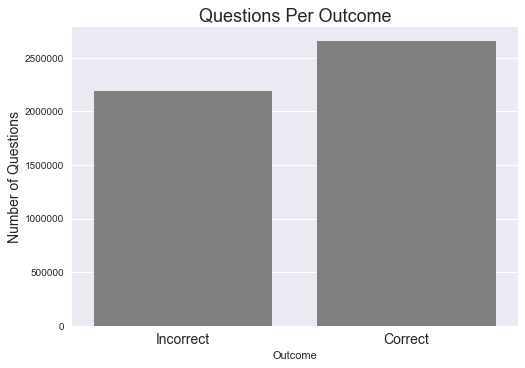

In [34]:
# Create bar plot for outcome distribution:
sns.countplot(data=df, x="outcome", color='grey');

# Create bar labels:
plt.xticks(np.arange(2), ('Incorrect', 'Correct'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('Outcome')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions Per Outcome', fontsize=18)

# Display the plot:
plt.show()

### Users and Unique Questions

<a id='user_id' href='#top'>back to menu</a>

#### `user_id`
---

1. How many users?
2. How many questions per user?
3. What are user statistics related to outcome?

In [35]:
# Count the number of unique user_id values:
print( ('Number of Users:'), len(df.reset_index().user_id.value_counts()) ) 

Number of Users: 179032


In [36]:
# Count and save the number of unique users:
questions_per_user = df.reset_index().user_id.value_counts()
print(questions_per_user.head(2))

# Convert to a dataframe, reset the index for future plotting and drop resulting extra column:
questions_per_user = questions_per_user.to_frame('question_count').reset_index().drop('index', axis='columns')

# Print the first 5 observations and inspect:
questions_per_user.head()

133472    10026
139564     7172
Name: user_id, dtype: int64


,question_count
0,10026
1,7172
2,7138
3,7019
4,6760


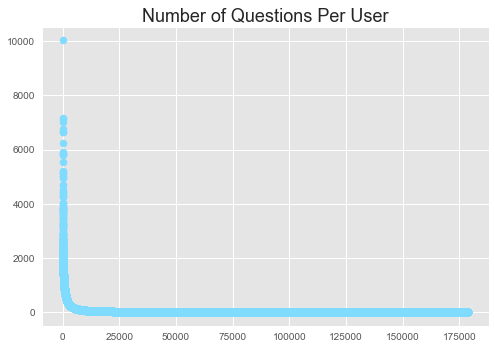

In [37]:
# Set the plot style:
plt.style.use('ggplot')

# Create questions_per_user scatter plot:
plt.scatter(questions_per_user.index, questions_per_user.question_count, color='#7fdbff')

# Create the title of the plot:
plt.title('Number of Questions Per User', fontsize=18)

# Set each axis scale and limits:
# plt.yscale('log')
# plt.xlim(0,2000)
# plt.xlim(0,1000)

# Display the plot:
plt.show()

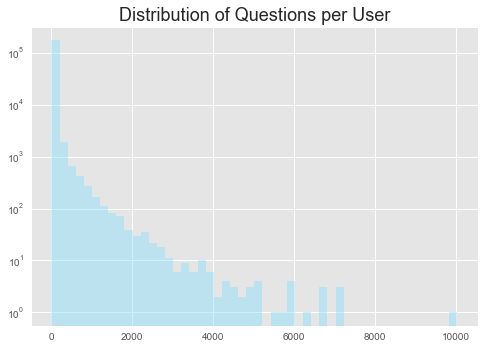

In [38]:
# Create a histogram of questions_per_user:
sns.distplot(questions_per_user, kde=False, color='#7fdbff')

# Set each axis scale and limits:
plt.yscale('log')
# plt.xlim(0,8000)

# Create a title:
plt.title('Distribution of Questions per User', fontsize=18)

# Display the plot:
plt.show() 

In [39]:
# Set up some variables to inspect ratios and distributions of correct, incorrect:

# Save the total number of entries per user in the outcome column:
question_count = df.reset_index().groupby('user_id')['outcome'].count()

# Save the total number of correct entries per user in the 'outcome' column;
# values are 0 (incorrect) and 1 (correct), so a sum of values in the column will do:
correct_answer_count = df.reset_index().groupby('user_id')['outcome'].sum()

# Save the total number of incorrect entries per user by subracting correct from total:
incorrect_answer_count = question_count.subtract(correct_answer_count)

# Save the ratio of correct answers per user, dividing by total:
ratio = correct_answer_count/question_count

# Build and save the dictionary and dataframe to look at user scores:
user_score = {
    'num_questions': question_count,
    'num_correct': correct_answer_count,
    'num_incorrect': incorrect_answer_count,
    'correct_ratio': ratio
}
df_user_score = pd.DataFrame(user_score)

# Rearrange the column order:
df_user_score = df_user_score[['num_correct', 'num_incorrect', 
                               'num_questions', 'correct_ratio']]

# Inspect the structure and values in the first 5 rows of the user score dataframe:
df_user_score.head() 

,num_correct,num_incorrect,num_questions,correct_ratio
user_id,,,,
0,5,2,7,0.714286
1,6,8,14,0.428571
2,2,6,8,0.250000
3,3,4,7,0.428571
4,7,4,11,0.636364


In [40]:
df_user_score.describe() 

,num_correct,num_incorrect,num_questions,correct_ratio
count,179032.000000,179032.000000,179032.000000,179032.000000
mean,14.831689,12.235472,27.067161,0.354104
std,92.511668,59.615109,146.022374,0.306944
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000
50%,2.000000,3.000000,6.000000,0.363636
75%,6.000000,7.000000,13.000000,0.600000
max,8018.000000,5328.000000,10026.000000,1.000000


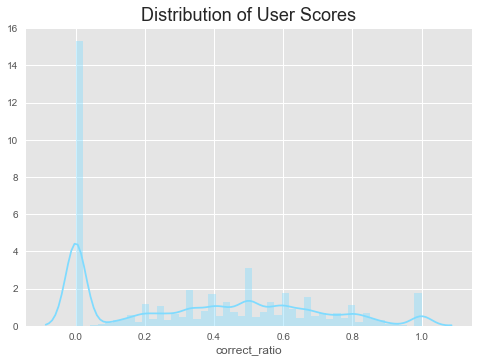

In [41]:
# Create a distribution plot of user scores (correct ratio)
sns.distplot(df_user_score.correct_ratio, color='#7fdbff')

# Create a title:
plt.title('Distribution of User Scores', fontsize=18)

# Display the plot:
plt.show()  

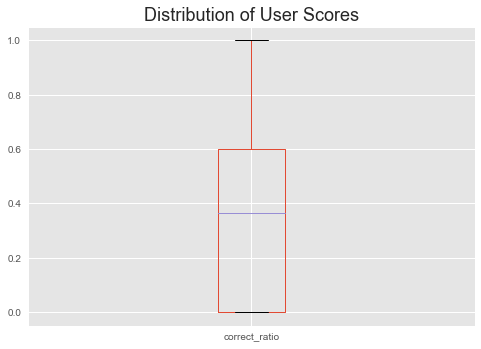

In [42]:
# Create a box plot of the user scores:
df_user_score.boxplot(column='correct_ratio')

# Create a title:
plt.title('Distribution of User Scores', fontsize=18)

# Display the plot:
plt.show() 

In [43]:
# Inspect distribution of score percentiles:
df_user_score['correct_ratio'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0    0.000000
0.1    0.000000
0.2    0.000000
0.3    0.000000
0.4    0.250000
0.5    0.363636
0.6    0.461538
0.7    0.545455
0.8    0.636364
0.9    0.781704
1.0    1.000000
Name: correct_ratio, dtype: float64

In [44]:
# Number of users with question count == 1
num_questions_filter = df_user_score.num_questions == 1
print( ('Number of users with only one question:'), len(df_user_score[num_questions_filter]) ) 

Number of users with only one question: 35900


In [45]:
# Number of users with score == 0
correct_ratio_filter = df_user_score.correct_ratio == 0
print( ('Number of users with no correct answers:'), len(df_user_score[correct_ratio_filter]) ) 

Number of users with no correct answers: 58313


In [46]:
# Number of users with 1 question & score of 0:
count_and_score_filter = num_questions_filter & correct_ratio_filter
print( ('Number of users with 1 question, incorrect:'), len(df_user_score[count_and_score_filter]) ) 

Number of users with 1 question, incorrect: 34343


<a id='question_id' href='#top'>back to menu</a>

#### question_id
---

1. How many unique questions?
2. How many questions per question_id?
3. What are the statistics related to outcome?

In [47]:
# Print the number of unique question_id values:
print(('Number of Unique Questions:'), (len( df.question_id.unique() )))

Number of Unique Questions: 6045


In [48]:
# Count and save the number of unique questions:
questions_per_questionid = df.question_id.value_counts()
questions_per_questionid.head(10)

4059    14416
1272    13584
4952    10455
1928    10351
4444    10272
1883    10178
2179    10151
5252     9353
5706     9262
1856     9087
Name: question_id, dtype: int64

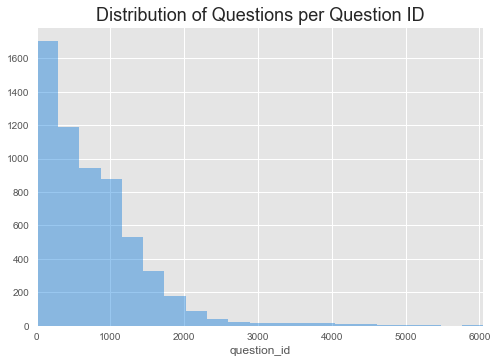

In [49]:
# Create a histogram of questions_per_questionid:
sns.distplot(questions_per_questionid, kde=False, color='#0074d9')

# Set each axis scale and limits:
# plt.yscale('log')
plt.xlim(0,6050)

# Create a title:
plt.title('Distribution of Questions per Question ID', fontsize=18)

# Display the plot:
plt.show() 

### Question Features

<a id='group_name' href='#top'>back to menu</a>

#### group_name
---

1. How many groups?
2. How many questions per group?
3. What are the statistics related to outcome?

In [50]:
# Print the number of unique group_name values:
print(('Number of Groups:'), (len( df.group_name.unique() )))

Number of Groups: 3


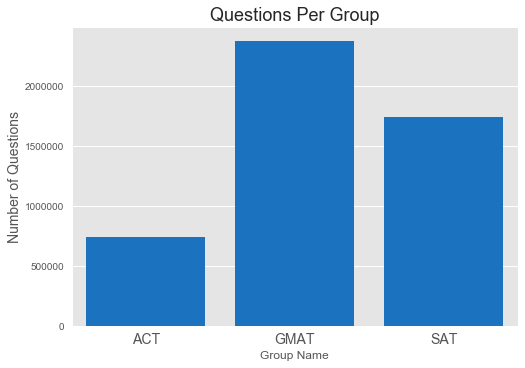

In [51]:
# Create bar plot for group_name distribution:
sns.countplot(data=df, x="group_name", color='#0074d9');

# Create bar labels:
# {'act':0, 'gmat':1, 'sat':2}
plt.xticks(np.arange(3), ('ACT', 'GMAT', 'SAT'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('Group Name')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions Per Group', fontsize=18)

# Display the plot:
plt.show()

<a id='track_name' href='#top'>back to menu</a>

#### track_name
---

1. How many tracks?
2. How many questions per track?
3. What are the statistics related to outcome?

In [52]:
# Print the number of unique track_name values:
print(('Number of Tracks:'), (len( df.track_name.unique() )))

Number of Tracks: 9


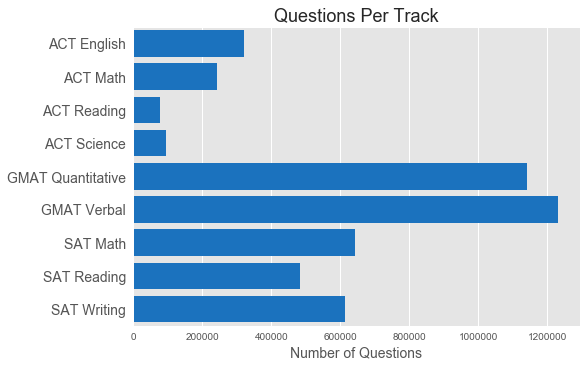

In [53]:
# Create bar plot for track_name distribution:
sns.countplot(data=df, y='track_name', color='#0074d9')

# Create bar labels:
tracks = ('ACT English', 'ACT Math', 'ACT Reading', 'ACT Science', 'GMAT Quantitative', 
              'GMAT Verbal', 'SAT Math', 'SAT Reading', 'SAT Writing')
plt.yticks(np.arange(len(tracks)), tracks, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions Per Track', fontsize=18)

# Display the plot:
plt.show()

<a id='subtrack_name' href='#top'>back to menu</a>

#### subtrack_name
---

1. How many subtracks?
2. How many questions per subtrack?
3. What are the statistics related to outcome?

In [54]:
# Print the number of unique subtrack_name values:
print(('Number of Subtracks:'), (len( df.subtrack_name.unique() )))

Number of Subtracks: 16


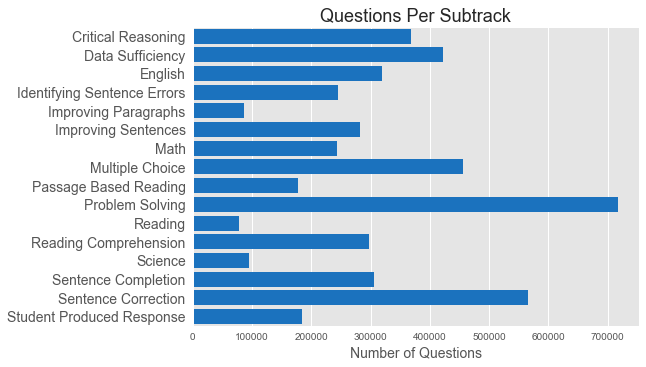

In [55]:
# Create bar plot for subtrack_name distribution:
sns.countplot(data=df, y='subtrack_name', color='#0074d9')

# Create bar labels:
subtracks = ('Critical Reasoning', 'Data Sufficiency', 'English', 'Identifying Sentence Errors', 
             'Improving Paragraphs', 'Improving Sentences', 'Math', 'Multiple Choice', 
             'Passage Based Reading', 'Problem Solving', 'Reading', 'Reading Comprehension', 
             'Science', 'Sentence Completion', 'Sentence Correction', 'Student Produced Response')
plt.yticks(np.arange(len(subtracks)), subtracks, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions Per Subtrack', fontsize=18)

# Display the plot:
plt.show()

<a id='tag_string' href='#top'>back to menu</a>

#### tag_string
---

<a id='question_type' href='#top'>back to menu</a>

#### question_type
---

1. How many question types?
2. How many questions per question type?
3. What are the statistics related to outcome?

In [56]:
# Print the number of unique question_type values:
print(('Number of Question Types:'), (len( df.question_type.unique() )))

Number of Question Types: 2


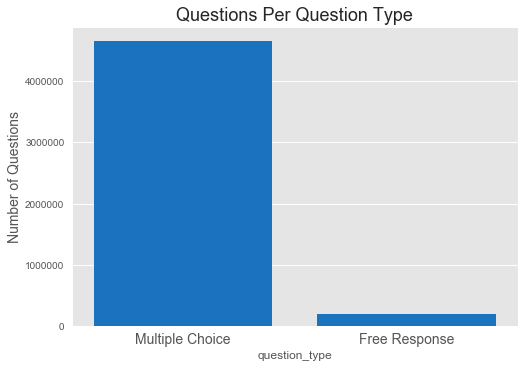

In [57]:
# Create bar plot for outcome distribution:
sns.countplot(data=df, x='question_type', color='#0074d9');

# Create bar labels:
plt.xticks(np.arange(2), ('Multiple Choice', 'Free Response'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('question_type')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions Per Question Type', fontsize=18)

# Display the plot:
plt.show()

### User-Driven Features

<a id='game_type' href='#top'>back to menu</a>

#### game_type
---

**`BookmarkGame: 0`** - values are like `ReviewGames`, but on specific questions the user has bookmarked.

**`ChallengeGame: 1`** - values are solo games where the user is taking a series of questions intended to challenge them and give them the best opportunities for learning.

**`CompetitiveGame: 2`** - values are the most different from other types of games. In these, once one user has answered correctly, the other users should be marked as 'skipped', and the game immediately proceeds to the next question. At the end of the game, whomever has answered the most questions correct wins.

**`ComputerAdaptiveTestGame: 3`** - values are the user answering questions on a full-length CAT, designed to mimic the algorithms used in the actual test, to ask them questions designed to maximize the information gain on the user's ability. TRYING TO IMPROVE THIS.

**`CustomGame: 4`** - values are normal games (like `PracticeGame`), but with some settings (such as specific areas or difficulty levels) chosen by the user.

**`DiagnosticGame: 5`** - values are solo games which are intended to give an initial rough assessment of the user's ability level.

**`NULL: 6`** - values represent a data collection failure.

**`PracticeGame: 7`** - is the main type of game: in these, everyone in the game is seeing the same question at the same time; once everyone has answered, the answer is displayed; once everyone is ready to continue, the round advances to a new question.  Note that these can be solo games as well.

**`RecitationGame: 8`** - represents a game led by a tutor through a series of questions, with the tutor controlling the pace of advancement.

**`ReviewGame: 9`** - is a solo game (essentially a solo `PracticeGame`) started by a user to review questions they have played in the past.

**`StudyHallGame: 10`** - is the newest type of game: in these, users are answering their own series of questions as though they were in a solo practice game, but there is a single "study hall" chat where people can ask for help on questions.

**`StudyTaskGame: 11`** - is a game where the user is answering questions in a common skill area, in order to achieve a task in their personalized study plan.

1. How many game types? 
2. How many questions per game type?
3. What are the statistics related to outcome?

In [58]:
# Confirm that there are 12 of game_type - 
# Print the number of unique game_type values:
print(('Number of Game Types:'), (len( df.game_type.unique() )))

Number of Game Types: 12


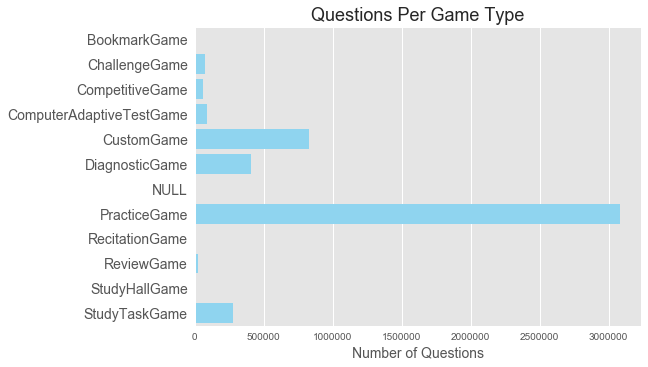

In [59]:
# Create bar plot for game_type distribution:
sns.countplot(data=df, y='game_type', color='#7fdbff')

# Create bar labels:
game_types = ('BookmarkGame', 'ChallengeGame', 'CompetitiveGame', 'ComputerAdaptiveTestGame', 
              'CustomGame', 'DiagnosticGame', 'NULL', 'PracticeGame', 'RecitationGame', 
              'ReviewGame', 'StudyHallGame', 'StudyTaskGame')
plt.yticks(np.arange(len(game_types)), game_types, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions Per Game Type', fontsize=18)

# Display the plot:
plt.show()

In [60]:
df.game_type.value_counts()

7     3082317
4      830466
5      406253
11     274908
3       91643
1       72356
2       57849
9       21383
0        3993
10       2628
8        2077
6          15
Name: game_type, dtype: int64

<a id='num_players' href='#top'>back to menu</a>

#### num_players
---



In [61]:
df.num_players.value_counts()

1     3247149
2      687295
3      402092
4      247379
5      181084
6       49340
7       16095
8        6855
9        3367
10       1868
11        880
12        549
13        465
15        292
14        280
19        131
16        104
21         94
20         94
18         87
23         81
22         56
27         50
17         48
31         32
33         30
24         26
30         24
45         18
25          8
32          7
29          6
51          2
Name: num_players, dtype: int64

## TIME DATA EXPLORATION
---

<a id='round_started_at' href='#top'>back to menu</a>

#### round_started_at
---

[use this as reference datetime]

In [62]:
df.reset_index().round_started_at.describe() 

count                 4845888
unique                4191566
top       2010-09-29 18:26:17
freq                       23
first     2008-08-26 18:34:30
last      2011-11-16 08:13:07
Name: round_started_at, dtype: object

<a id='answered_at' href='#top'>back to menu</a>

#### answered_at
---

[minutes from reference datetime]

In [63]:
df.answered_at.describe()

count                 4293889
unique                4144328
top       2011-11-03 17:01:29
freq                        6
first     2008-08-26 18:39:02
last      2011-11-16 08:13:34
Name: answered_at, dtype: object

<a id='deactivated_at' href='#top'>back to menu</a>

#### deactivated_at
---

[minutes from reference datetime]

In [64]:
df.deactivated_at.describe()

count                 4845877
unique                4204922
top       2010-09-29 18:27:26
freq                       22
first     2008-08-26 18:34:57
last      2011-11-16 08:13:35
Name: deactivated_at, dtype: object

<a id='deactivated_at' href='#top'>back to menu</a>

#### round_ended_at
---

[minutes from reference datetime]

<a id='deactivated_at' href='#top'>back to menu</a>

#### round_duration
---

[minutes from reference datetime]

<a id='date_of_test' href='#top'>back to menu</a>

## Save Clean DataFrame

In [65]:
# Inspect one more time:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4845888 entries, (0, 2011-08-26 16:54:31) to (179105, 2010-05-26 06:30:43)
Data columns (total 13 columns):
answered_at       datetime64[ns]
deactivated_at    datetime64[ns]
round_ended_at    datetime64[ns]
round_duration    datetime64[ns]
outcome           int64
group_name        category
track_name        category
subtrack_name     category
tag_ids           object
question_id       category
question_type     category
game_type         category
num_players       int64
dtypes: category(6), datetime64[ns](4), int64(2), object(1)
memory usage: 526.7+ MB


In [66]:
# Inspect one more time:
df.head()

answered_at      deactivated_at  \
user_id round_started_at                                              
0       2011-08-26 16:54:31 2011-08-26 16:55:51 2011-08-26 16:55:53   
        2011-08-26 16:56:12 2011-08-26 16:56:31 2011-08-26 16:56:33   
        2011-08-26 16:56:39 2011-08-26 16:56:54 2011-08-26 16:56:55   
        2011-08-26 16:57:05 2011-08-26 16:57:24 2011-08-26 16:57:25   
        2011-08-26 16:57:29 2011-08-26 16:57:51 2011-08-26 16:57:52   

                                 round_ended_at round_duration  outcome  \
user_id round_started_at                                                  
0       2011-08-26 16:54:31 2011-08-26 16:55:51            NaT        1   
        2011-08-26 16:56:12 2011-08-26 16:56:31            NaT        1   
        2011-08-26 16:56:39 2011-08-26 16:56:54            NaT        0   
        2011-08-26 16:57:05 2011-08-26 16:57:24            NaT        1   
        2011-08-26 16:57:29 2011-08-26 16:57:51            NaT        1   

                            group_name track_name subtrack_name  \
user_id round_started_at                                          
0       2011-08-26 16:54:31          0          2            10   
        2011-08-26 16:56:12          0          2            10   
        2011-08-26 16:56:39          0          2            10   
        2011-08-26 16:57:05          0          2            10   
        2011-08-26 16:57:29          0          2            10   

                                          tag_ids question_id question_type  \
user_id round_started_at                                                      
0       2011-08-26 16:54:31   [17, 122, 171, 206]        5937             0   
        2011-08-26 16:56:12    [0, 100, 171, 206]         294             0   
        2011-08-26 16:56:39   [40, 124, 171, 206]        5625             0   
        2011-08-26 16:57:05   [18, 139, 171, 206]        4322             0   
        2011-08-26 16:57:29  [104, 127, 171, 206]        5024             0   

                            game_type  num_players  
user_id round_started_at                            
0       2011-08-26 16:54:31         7            1  
        2011-08-26 16:56:12         7            1  
        2011-08-26 16:56:39         7            1  
        2011-08-26 16:57:05         7            1  
        2011-08-26 16:57:29         7            1

In [67]:
# df.to_csv('../data/interim/training_clean.csv')